## Import Libraries

In [2]:
# Set seed for reproducibility
seed = 42
# Import necessary libraries
import os
# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import cv2
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.keras.applications import InceptionV3, ResNet50, VGG16, VGG19, MobileNet, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Flatten, Dense, Rescaling, Resizing, GlobalAveragePooling2D, Dropout
from collections import Counter
import albumentations as A
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import CategoricalCrossentropy

# Configure plot display settings

sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## Load Data

This code looks for clean data in the input and output directories, in case it was already created. If not found then it tries to perform data cleaning on the original dataset.

In [5]:

original_data_path = "/kaggle/input/bloodcell/training_set.npz"
cleaned_data_path  = ["/kaggle/input/cleaneddataset/cleaned_images.npz", "/kaggle/working/cleaned_images.npz"]

found_clean_data = False
for path in cleaned_data_path:
    if os.path.exists(path):
        print(f"Loading data from: {path}")
        data = np.load(path)
        
        images = data['images']
        labels = data['labels']

        found_clean_data = True
        break
        
if found_clean_data == False:
    print(f"Loading data from: {original_data_path}")
    data = np.load(original_data_path)

    images, labels = data['images'], data['labels']
    selected_indices = [13202, 13690]

    # Load pretrained VGG16 model
    vgg_model = VGG16(weights='imagenet')
    feature_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('fc1').output)

    def preprocess_and_extract_features(images, batch_size=64):
        all_features = []
        for start in range(0, len(images), batch_size):
            batch_images = images[start:start + batch_size]
            processed_images = preprocess_images(batch_images)
            batch_features = feature_extractor.predict(processed_images)
            all_features.append(batch_features)
        return np.vstack(all_features)

    def preprocess_images(images):
        processed_images = []
        for img in images:
            img_resized = cv2.resize(img, (224, 224))
            img_resized = img_to_array(img_resized)
            img_resized = np.expand_dims(img_resized, axis=0)
            img_resized = preprocess_input(img_resized)
            processed_images.append(img_resized)
        return np.vstack(processed_images)

    # Process images in batches to save memory
    features = preprocess_and_extract_features(images)

    # Function to get similar images
    def get_similar_images(indices, threshold=0.8):
        selected_features = features[indices]
        similarities = cosine_similarity(selected_features, features)
        similar_indices = np.where(np.max(similarities, axis=0) >= threshold)[0]
        return similar_indices, similarities

    # Identify similar images
    similar_indices, similarities = get_similar_images(selected_indices, threshold=0.8)

    # Separate datasets
    def resize_back_to_original(images, target_size=(96, 96)):
        resized_images = [cv2.resize(img, target_size) for img in images]
        return np.array(resized_images)

    outlier_images = resize_back_to_original(images[similar_indices])  # Resize back to 96x96
    outlier_labels = labels[similar_indices]

    remaining_indices = np.setdiff1d(np.arange(images.shape[0]), similar_indices)
    images = resize_back_to_original(images[remaining_indices])  # Resize back to 96x96
    labels = labels[remaining_indices]

    print(f"Number of similar images: {outlier_images.shape[0]}")
    print(f"Number of remaining images: {images.shape[0]}")

    # Save the datasets
    np.savez("/kaggle/working/cleaned_images.npz", images=images, labels=labels)


Loading data from: /kaggle/input/cleaneddataset/cleaned_images.npz


In [7]:
label_list = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}
# Save unique labels
unique_labels = list(label_list.values())

print("images data shape: ", images.shape)
print("labels data shape: ", labels.shape)

images data shape:  (11959, 96, 96, 3)
labels data shape:  (11959, 1)


### print the first element of each class

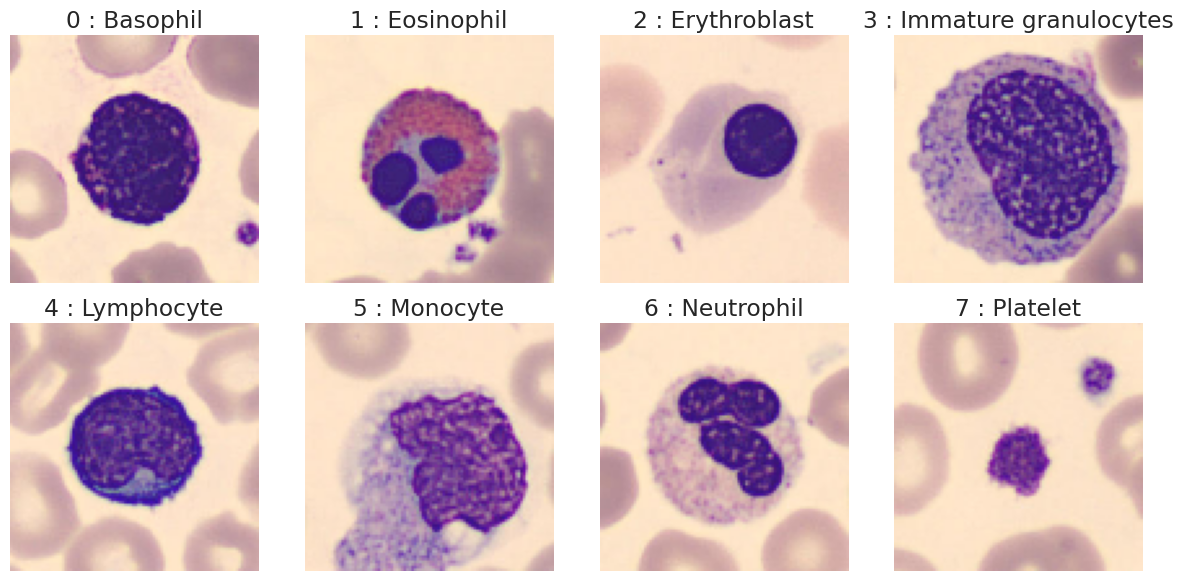

In [8]:
num_classes = 8  # Number of classes
first_indices = []  # To store the first occurrence of each class

# Find the first index of each class
for class_label in range(num_classes):
    for idx, label in enumerate(labels):
        if label == class_label:
            first_indices.append(idx)
            break

# Check if we have found all classes
if len(first_indices) < num_classes:
    raise ValueError("Some classes are missing in the dataset!")

# Plot the first occurrence of each class in a 2x4 grid
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 rows, 4 columns

for i, idx in enumerate(first_indices):
    row, col = divmod(i, 4)  # Determine the row and column in the grid
    ax = axes[row, col]
    ax.imshow(np.squeeze(images[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{labels[idx][0]} : {label_list[labels[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()


### plot the distribution of each class

Total number of images:  11959
Counting occurrences of target classes:
digit
6    2330
1    2181
3    2026
7    1643
2    1085
5     993
0     852
4     849
Name: count, dtype: int64


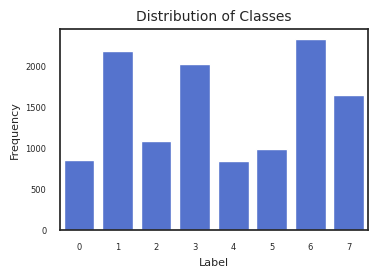

In [9]:
# Inspect the target
print('Total number of images: ', labels.size)
print('Counting occurrences of target classes:')
print(pd.DataFrame(labels, columns=['digit'])['digit'].value_counts())

# Convert labels to a DataFrame for easy counting and plotting
label_df = pd.DataFrame(labels, columns=['digit'])

# Count occurrences of each label
label_counts = label_df['digit'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(4, 3))
sns.barplot(x=label_counts.index, y=label_counts.values, color='#4169E1')  # Same color for all bars

# Set labels and title with reduced font size
plt.xlabel('Label', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.title('Distribution of Classes', fontsize=10)

# Reduce tick label font size
plt.tick_params(axis='both', labelsize=6)

# Show the plot
plt.tight_layout()
plt.show()


We have class imbalance, so we can use augmentation techniques

In [13]:
# Set up target counts for each class
target_class_counts = {0:1500, 2:1500, 4:1500, 5:1500}  # Example: Adjust target counts as needed

# Define an advanced augmentation pipeline (unchanged)
augmentation_pipeline = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    # A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=1, min_height=4, min_width=4, p=0.5)
])

# Define the AugmentedDataGenerator class (unchanged)
class AugmentedDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=32, augment=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.indices = np.arange(len(images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.images[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        if self.augment:
            batch_images = [augmentation_pipeline(image=image)["image"] for image in batch_images]

        batch_images = np.array(batch_images, dtype="float32")
        batch_labels = np.array(batch_labels)
        return batch_images, batch_labels

    def on_epoch_end(self):
        np.random.shuffle(self.indices)


# Initialize augmented images and labels
augmented_images = []
augmented_labels = []

# Process each class specified in the target counts
for target_class, target_count in target_class_counts.items():
    # Find indices and count for the current class
    class_indices = np.where(labels == target_class)[0]
    num_class_images = len(class_indices)
    augmentation_needed = max(0, target_count - num_class_images)

    # Skip if no augmentation is needed
    if augmentation_needed == 0:
        continue

    # Select class images and labels
    class_images = images[class_indices]
    class_labels = labels[class_indices]

    # Initialize the generator for the current class
    generator = AugmentedDataGenerator(class_images, class_labels, batch_size=32, augment=True)

    # Generate augmented data for the current class
    class_augmented_images = []
    class_augmented_labels = []
    for batch_images, batch_labels in generator:
        class_augmented_images.extend(batch_images)
        class_augmented_labels.extend(batch_labels)

        if len(class_augmented_images) >= augmentation_needed:
            class_augmented_images = class_augmented_images[:augmentation_needed]
            class_augmented_labels = class_augmented_labels[:augmentation_needed]
            break

    # Add to the global augmented dataset
    augmented_images.extend(class_augmented_images)
    augmented_labels.extend(class_augmented_labels)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels).reshape(-1, 1)

# Combine the original images and labels with the augmented ones
final_images = np.concatenate((images, augmented_images), axis=0)
final_labels = np.concatenate((labels.reshape(-1, 1), augmented_labels), axis=0)

# Print final data shape and distribution
print("Final images shape:", final_images.shape)
print("Final labels shape:", final_labels.shape)
print("New label distribution after augmentation:\n", Counter(labels.flatten()))
print("New label distribution after augmentation:\n", Counter(final_labels.flatten()))


Final images shape: (14180, 96, 96, 3)
Final labels shape: (14180, 1)
New label distribution after augmentation:
 Counter({6: 2330, 1: 2181, 3: 2026, 7: 1643, 2: 1085, 5: 993, 0: 852, 4: 849})
New label distribution after augmentation:
 Counter({6: 2330, 1: 2181, 3: 2026, 7: 1643, 2: 1500, 5: 1500, 0: 1500, 4: 1500})


## Distribution after augmentation

Total number of images:  14180
Counting occurrences of target classes:
digit
6    2330
1    2181
3    2026
7    1643
2    1500
5    1500
0    1500
4    1500
Name: count, dtype: int64


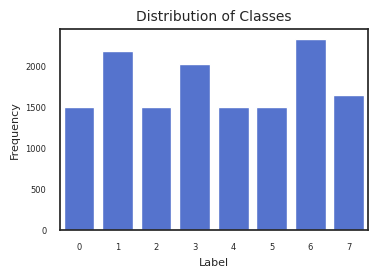

In [14]:
# Inspect the target
print('Total number of images: ', final_labels.size)
print('Counting occurrences of target classes:')
print(pd.DataFrame(final_labels, columns=['digit'])['digit'].value_counts())

# Convert labels to a DataFrame for easy counting and plotting
label_df = pd.DataFrame(final_labels, columns=['digit'])

# Count occurrences of each label
label_counts = label_df['digit'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(4, 3))
sns.barplot(x=label_counts.index, y=label_counts.values, color='#4169E1')  # Same color for all bars

# Set labels and title with reduced font size
plt.xlabel('Label', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.title('Distribution of Classes', fontsize=10)

# Reduce tick label font size
plt.tick_params(axis='both', labelsize=6)

# Show the plot
plt.tight_layout()
plt.show()


## Inspecting the augmented images

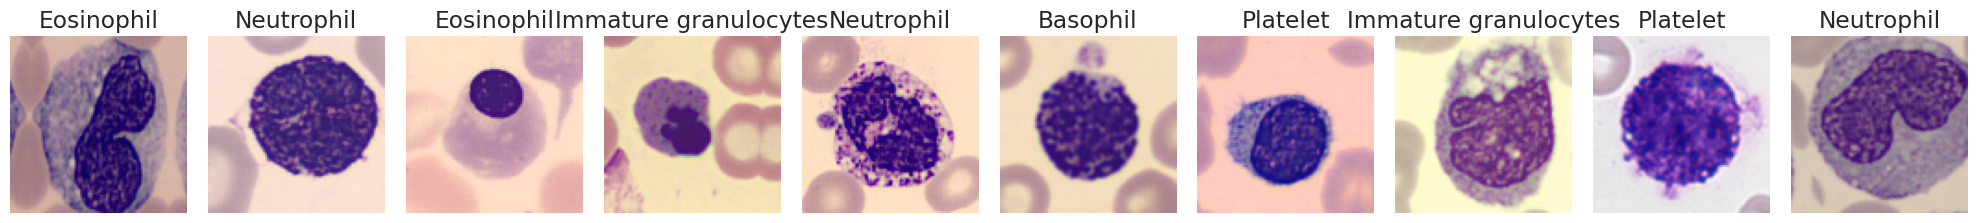

In [23]:
# Display a random sample of images from the augmented dataset
num_img = 10
random_indices = random.sample(range(len(augmented_images)), num_img)
fig, axes = plt.subplots(1, num_img, figsize=(20, 10))

# Iterate through the selected images
for i, idx in enumerate(random_indices):
    ax = axes[i]
    # Remove `np.squeeze` and `vmin`, `vmax` if pixel values are [0, 255]
    ax.imshow(np.squeeze(images[idx]), vmin=0., vmax=1.)
    ax.imshow(augmented_images[idx].astype('uint8'))  # Ensure uint8 for display
    ax.set_title(f'{label_list[labels[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

## Process Data

In [24]:
offline_augmented_data = False

if offline_augmented_data == True:
    X_set = (final_images / 255.0).astype('float32')
    y_set = tfk.utils.to_categorical(final_labels)

else:
    X_set = (images / 255.0).astype('float32')
    y_set = tfk.utils.to_categorical(labels)


# Split data: 80% train, 10% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X_set, y_set, test_size=0.2, stratify=y_set, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training Data Shape: (9567, 96, 96, 3)
Training Label Shape: (9567, 8)
Validation Data Shape: (1196, 96, 96, 3)
Validation Label Shape: (1196, 8)
Test Data Shape: (1196, 96, 96, 3)
Test Label Shape: (1196, 8)


In [25]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


## Custome Model: UNet Architecture

In [26]:
# Number of training epochs
epochs = 100

# Batch size for training
batch_size = 128

# Learning rate: step size for updating the model's weights
learning_rate = 0.0001

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Epochs: 100
Batch Size: 128
Learning Rare: 0.0001


In [27]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    augmentation=None,
    seed=seed
):
    tf.random.set_seed(seed)

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

     # Apply optional data augmentation, then first convolutional layer
    if augmentation == None:
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(input_layer)
    else:
        x = augmentation(input_layer)
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(x)

    # Contracting Path
    # Block 1
    x1 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(input_layer)
    x1 = tfkl.ReLU()(x1)
    x1_pool = tfkl.MaxPooling2D(pool_size=(2, 2), name='pool1')(x1)

    # Block 2
    x2 = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x1_pool)
    x2 = tfkl.ReLU()(x2)
    x2_pool = tfkl.MaxPooling2D(pool_size=(2, 2), name='pool2')(x2)

    # Block 3
    x3 = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x2_pool)
    x3 = tfkl.ReLU()(x3)
    x3_pool = tfkl.MaxPooling2D(pool_size=(2, 2), name='pool3')(x3)

    # Block 4
    x4 = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x3_pool)
    x4 = tfkl.ReLU()(x4)
    x4_pool = tfkl.MaxPooling2D(pool_size=(2, 2), name='pool4')(x4)

    # Bottleneck (Center)
    bottleneck = tfkl.Conv2D(filters=1024, kernel_size=3, padding='same', name='conv_bottleneck')(x4_pool)
    bottleneck = tfkl.ReLU()(bottleneck)

    # Expanding Path
    # Block 5 (Up-sample and Concatenate)
    x5_up = tfkl.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', name='upconv1')(bottleneck)
    x5 = tfkl.Concatenate()([x5_up, x4])  # Skip connection
    x5 = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv5')(x5)
    x5 = tfkl.ReLU()(x5)

    # Block 6
    x6_up = tfkl.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', name='upconv2')(x5)
    x6 = tfkl.Concatenate()([x6_up, x3])  # Skip connection
    x6 = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv6')(x6)
    x6 = tfkl.ReLU()(x6)

    # Block 7
    x7_up = tfkl.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', name='upconv3')(x6)
    x7 = tfkl.Concatenate()([x7_up, x2])  # Skip connection
    x7 = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv7')(x7)
    x7 = tfkl.ReLU()(x7)

    # Block 8
    x8_up = tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', name='upconv4')(x7)
    x8 = tfkl.Concatenate()([x8_up, x1])  # Skip connection
    x8 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv8')(x8)
    x8 = tfkl.ReLU()(x8)

    # Global average pooling (flattening the feature map)
    x9 = tfkl.GlobalAveragePooling2D()(x8)

    # Fully connected (Dense) layer for classification output
    output_layer = tfkl.Dense(units=output_shape, activation='softmax', name='output')(x9)

    # Model definition
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='UNet')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Input             │ (None, 96, 96,  │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1 (Conv2D)    │ (None, 96, 96,  │     1,792 │ Input[0][0]    │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu (ReLU)      │ (None, 96, 96,  │         0 │ conv1[0][0]    │   -   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1             │ (None, 48, 48,  │         0 │ re_lu[0][0]    │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2 (Conv2D)    │ (None, 48, 48,  │    73,856 │ pool1[0][0]    │   Y   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_1 (ReLU)    │ (None, 48, 48,  │         0 │ conv2[0][0]    │   -   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool2             │ (None, 24, 24,  │         0 │ re_lu_1[0][0]  │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv3 (Conv2D)    │ (None, 24, 24,  │   295,168 │ pool2[0][0]    │   Y   │
│                   │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_2 (ReLU)    │ (None, 24, 24,  │         0 │ conv3[0][0]    │   -   │
│                   │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool3             │ (None, 12, 12,  │         0 │ re_lu_2[0][0]  │   -   │
│ (MaxPooling2D)    │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv4 (Conv2D)    │ (None, 12, 12,  │ 1,180,160 │ pool3[0][0]    │   Y   │
│                   │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_3 (ReLU)    │ (None, 12, 12,  │         0 │ conv4[0][0]    │   -   │
│                   │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool4             │ (None, 6, 6,    │         0 │ re_lu_3[0][0]  │   -   │
│ (MaxPooling2D)    │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv_bottleneck   │ (None, 6, 6,    │ 4,719,616 │ pool4[0][0]    │   Y   │
│ (Conv2D)          │ 1024)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_4 (ReLU)    │ (None, 6, 6,    │         0 │ conv_bottlene… │   -   │
│                   │ 1024)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ upconv1           │ (None, 12, 12,  │ 4,719,104 │ re_lu_4[0][0]  │   Y   │
│ (Conv2DTranspose) │ 512)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate       │ (None, 12, 12,  │         0 │ upconv1[0][0], │   - 

 Total params: 18,806,792 (71.74 MB)

 Trainable params: 18,806,792 (71.74 MB)

 Non-trainable params: 0 (0.00 B)

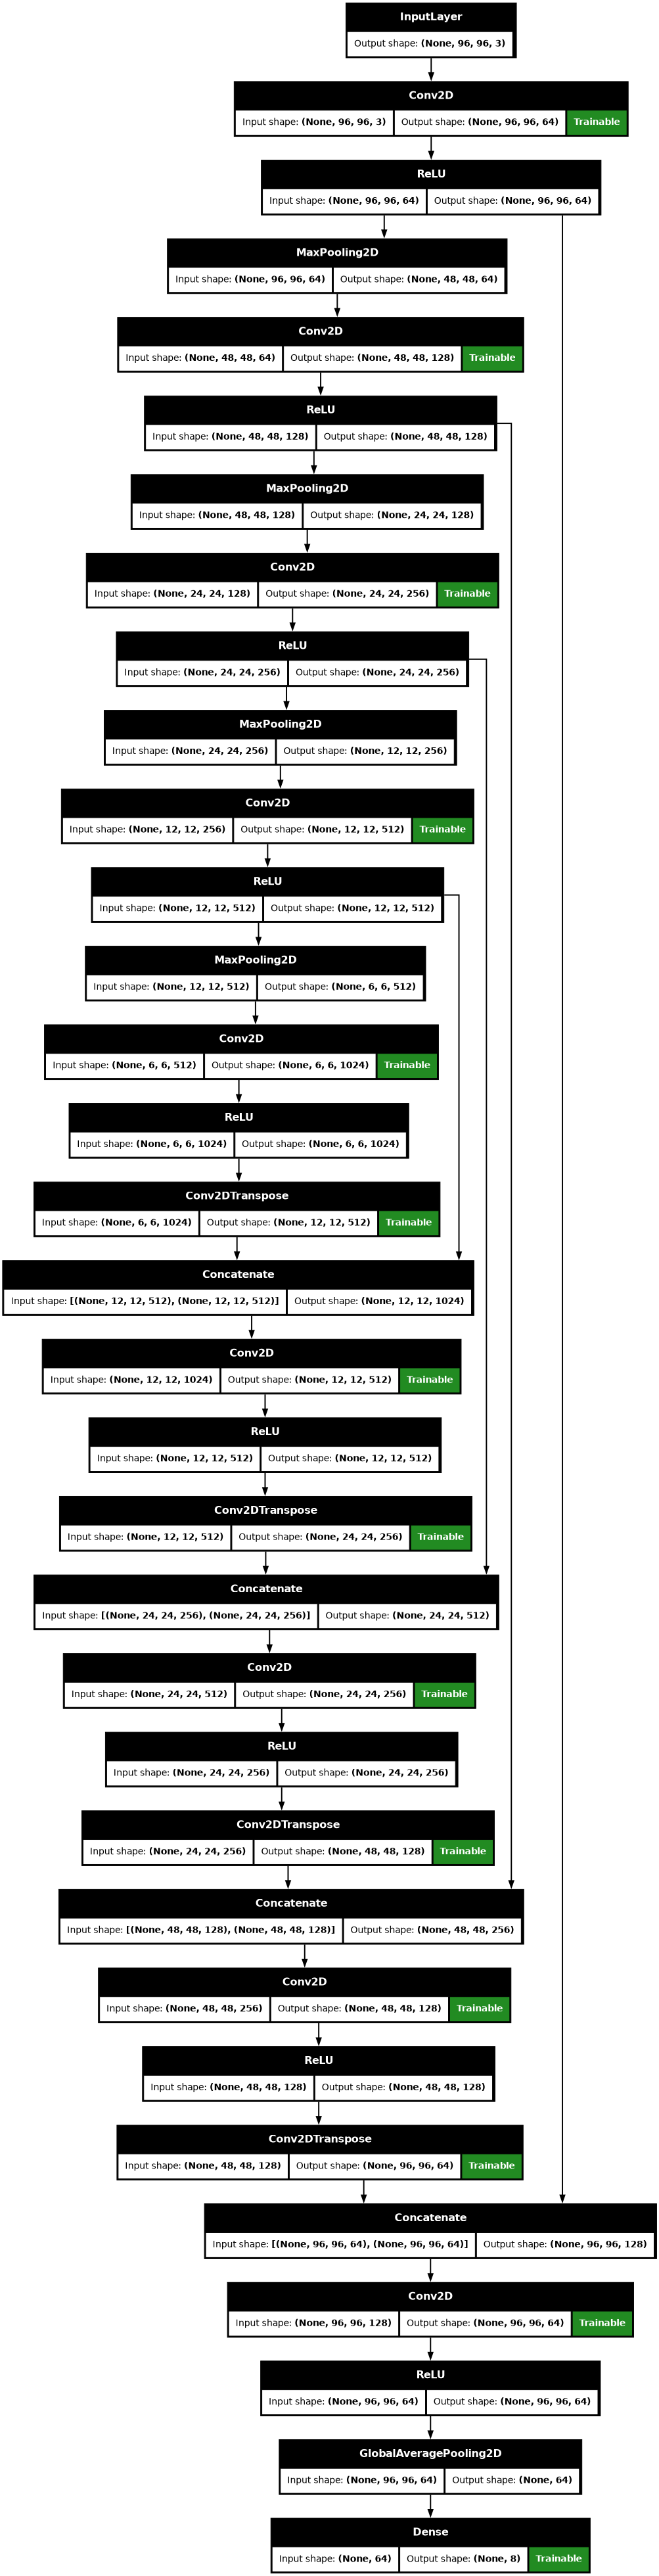

In [28]:
# Build the model with specified input and output shapes

augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    tfkl.RandomContrast(0.75),
], name='preprocessing')

# Build the model with specified input and output shapes
model = build_model(augmentation=augmentation)

# model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## Train the Model

In [30]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [31]:
# Train the model with early stopping callback

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history


# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'CIFAR10_CNN_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/100


I0000 00:00:1732482994.180797     103 service.cc:145] XLA service 0x7cd8c00210f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732482994.180853     103 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732482994.180857     103 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732483058.449920     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.1802 - loss: 2.0293 - val_accuracy: 0.3077 - val_loss: 1.7762
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 615ms/step - accuracy: 0.4210 - loss: 1.5159 - val_accuracy: 0.5033 - val_loss: 1.3050
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 615ms/step - accuracy: 0.4963 - loss: 1.2709 - val_accuracy: 0.5184 - val_loss: 1.2761
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 614ms/step - accuracy: 0.5213 - loss: 1.2235 - val_accuracy: 0.5368 - val_loss: 1.2507
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 614ms/step - accuracy: 0.5373 - loss: 1.1957 - val_accuracy: 0.5610 - val_loss: 1.2127
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 616ms/step - accuracy: 0.5640 - loss: 1.1444 - val_accuracy: 0.6263 - val_loss: 1.0778
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 615ms/step - accuracy: 0.6291 - loss: 0.9866 - val_accuracy: 0.7007 - val_loss: 0.7934
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 617ms/step - accuracy: 0.7023 - loss: 0.7615 - val_accuracy: 

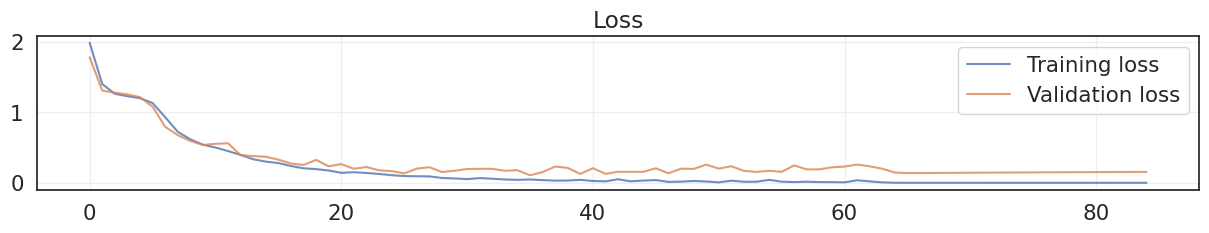

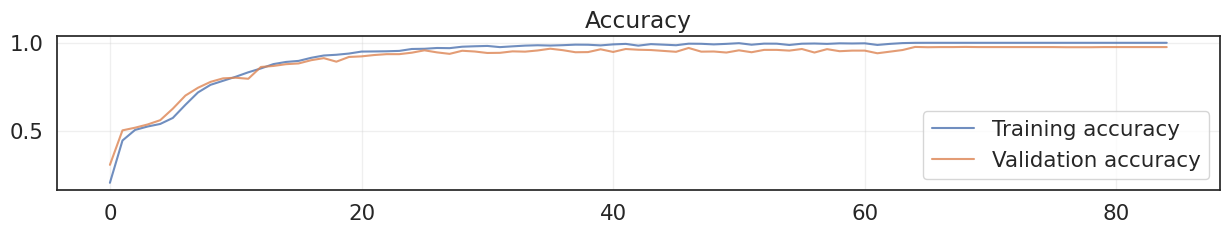

In [32]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.savefig('loss_plot.png', format='png', dpi=300)  # Save the plot as a PNG file

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.savefig('accuracy_plot.png', format='png', dpi=300)  # Save the plot as a PNG file

plt.show()  # Display the plots


In [33]:
! ls

CIFAR10_CNN_97.66.keras  accuracy_plot.png  loss_plot.png  model.png


In [34]:
# Load the saved model
model = tfk.models.load_model('CIFAR10_CNN_97.66.keras')

# Display a summary of the model architecture
# model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
# tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

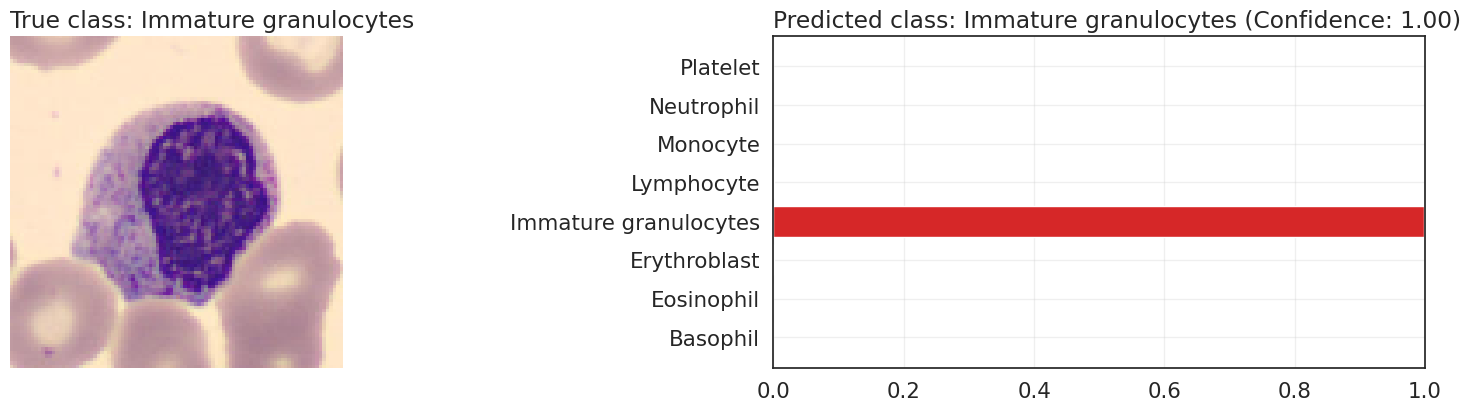

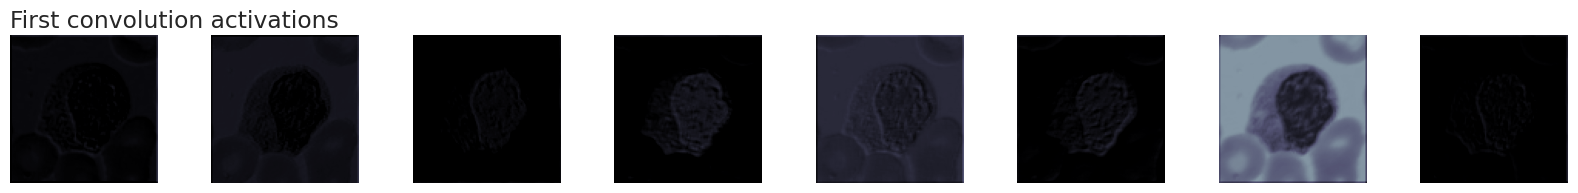

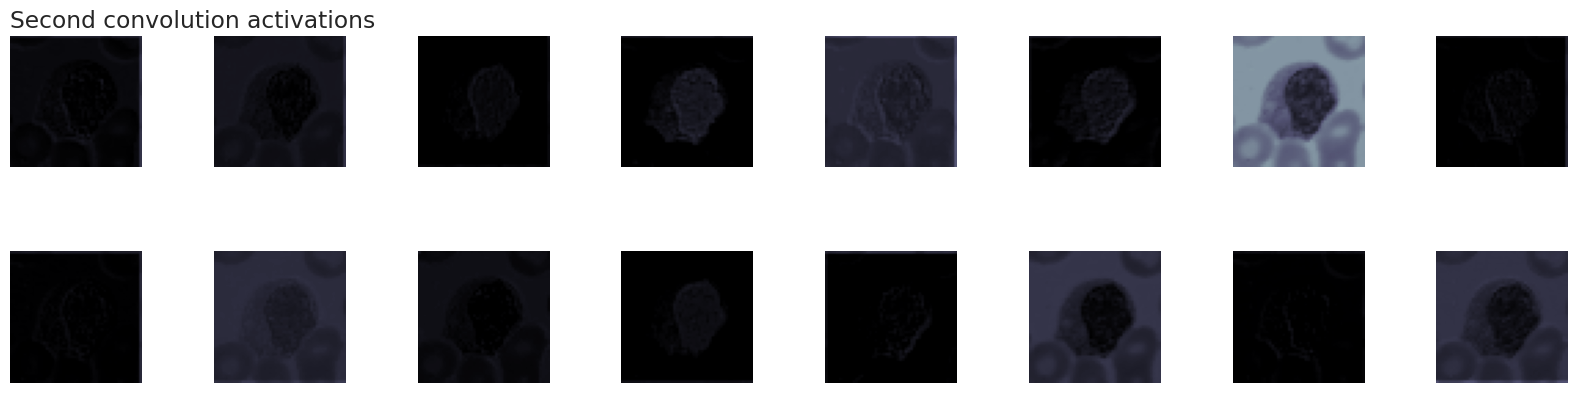

In [35]:
def extract_activations(model, X, num_images):
    # Identify the first convolutional layer

    first_conv_index = None
    for i, layer in enumerate(model.layers):
        if isinstance(layer, tfk.layers.Conv2D):
            first_conv_index = i
            break

    if first_conv_index is None:
        raise ValueError("The model does not contain a 2D convolution")

    # Extract activations from the first convolutional layer
    first_conv = tfk.Sequential(model.layers[:first_conv_index + 1])
    first_activations = first_conv(X[:num_images])

    # Identify the first pooling layer after the first convolution
    pooling_index = None
    for i, layer in enumerate(model.layers[first_conv_index + 1:], start=first_conv_index + 1):
        if isinstance(layer, (tfk.layers.MaxPooling2D, tfk.layers.AveragePooling2D)):
            pooling_index = i
            break

    if pooling_index is None:
        raise ValueError("The model does not contain a 2D pooling operation after the first convolution")

    # Extract activations from the first convolution and the first pooling layer
    second_conv = tfk.Sequential(model.layers[:pooling_index + 1])
    second_activations = second_conv(X[:num_images])

    return first_activations, second_activations

def find_last_conv_layer(model):
    # Identify the last convolutional layer in the model
    for layer in reversed(model.layers):
        if isinstance(layer, tfk.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

def visualize(model, X, y, unique_labels, num_images=50, display_activations=True):
    # Extract activations from the model
    first_activations, second_activations = extract_activations(model, X, num_images)
   
    # Select a random image for prediction and visualisation
    image = np.random.randint(0, num_images)
    predictions = model.predict(np.expand_dims(X[image], axis=0), verbose=0)
    class_int = np.argmax(predictions[0])
    class_str = unique_labels[class_int]

    # Create figure layout for displaying the image and predictions
    fig = plt.figure(constrained_layout=True, figsize=(16, 4))
    gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1.5, 1.5], wspace=0)

    # Display the selected image with the true class
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title(f"True class: {unique_labels[np.argmax(y[image])]}", loc='left')
    if X[image].shape[-1] == 1:
        ax1.imshow(np.squeeze(X[image]), cmap='bone', vmin=0., vmax=1.)
    else:
        ax1.imshow(np.squeeze(X[image]), vmin=0., vmax=1.)
    ax1.axis('off')


    # Display the prediction bar
    ax2 = fig.add_subplot(gs[1])
    ax2.barh(unique_labels, np.squeeze(predictions, axis=0), color=plt.get_cmap('tab10').colors)
    ax2.set_title(f"Predicted class: {class_str} (Confidence: {max(np.squeeze(predictions, axis=0)):.2f})", loc='left')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0.0, 1.0)

    plt.show()

    # Display activations if required
    if display_activations:
        # Visualise the activations from the first convolutional layer
        fig, axes = plt.subplots(1, 8, figsize=(16, 14))
        for i in range(8):
            ax = axes[i]
            ax.imshow(first_activations[image, :, :, i], cmap='bone', vmin=0., vmax=1.)
            ax.axis('off')
            if i == 0:
                ax.set_title('First convolution activations', loc='left')
        plt.tight_layout()
        plt.show()

        # Visualise the activations from the first pooling layer
        fig, axes = plt.subplots(2, 8, figsize=(16, 5))
        for i in range(16):
            ax = axes[i // 8, i % 8]
            ax.imshow(second_activations[image, :, :, i], cmap='bone', vmin=0., vmax=1.)
            ax.axis('off')
            if i == 0:
                ax.set_title('Second convolution activations', loc='left')

        plt.tight_layout()
        plt.show()


# Example usage
visualize(model, X_test, y_test, unique_labels, display_activations=True)

In [36]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (1196, 8)


Accuracy score over the test set: 0.9783
Precision score over the test set: 0.9786
Recall score over the test set: 0.9783
F1 score over the test set: 0.9783


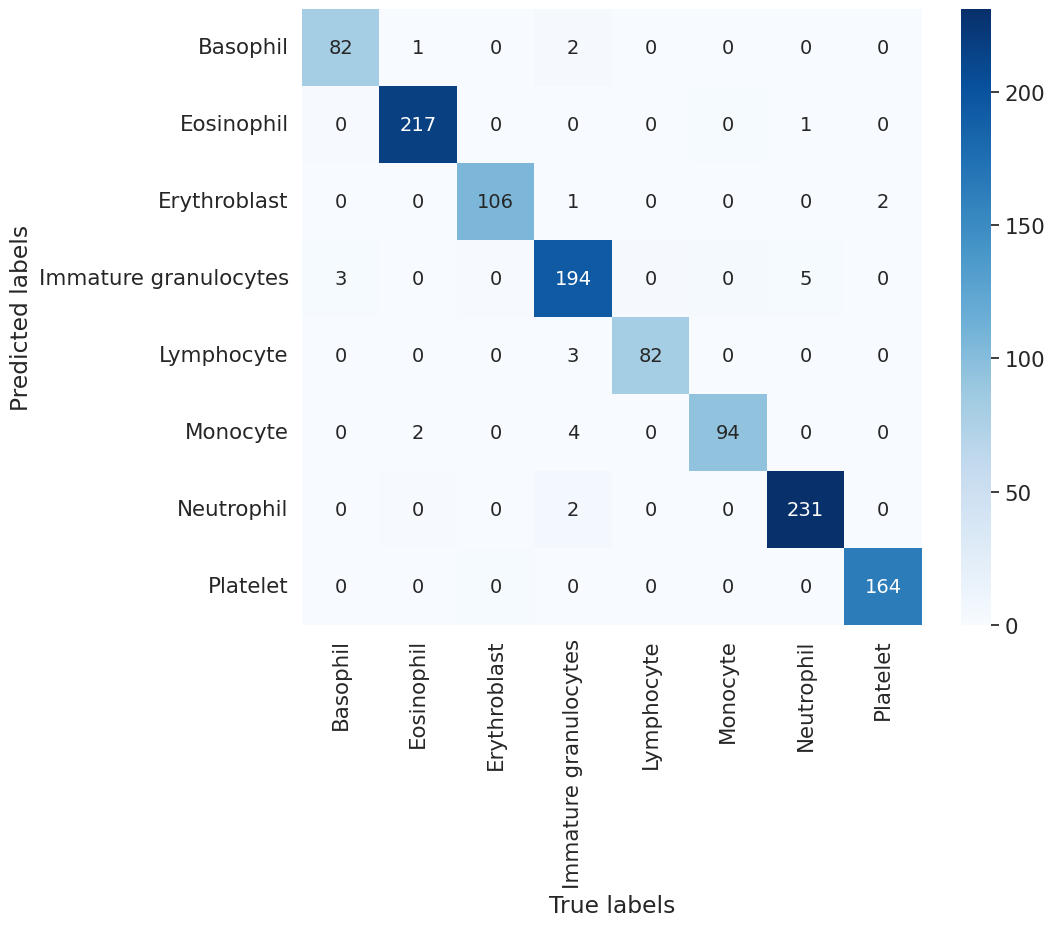

In [37]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(label_list.values()), yticklabels=list(label_list.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Transfer Learning

In [39]:
# select the model between : inceptionv3, resnet50, vgg16. vgg19, mobilenet, efficientnetb0
selected_pretrained_model = 'mobilenet'

# Number of training epochs
epochs = 20
batch_size = 128
learning_rate = 0.0001
patience = 10

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

# Print the defined parameters
print("Pretrained Model:", selected_pretrained_model)
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)
print("Early stopping with patience:", patience)

Pretrained Model: mobilenet
Epochs: 20
Batch Size: 128
Learning Rate: 0.0001
Early stopping with patience: 10


In [40]:
def build_transfer_learning_model(
    model_name,
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    augmentation=None,
    seed=42
):
    
    # Set random seed for reproducibility
    tf.random.set_seed(seed)
    
    # Input layer
    inputs = Input(shape=input_shape, name='Input')

    # Determine the resizing dimensions based on the model
    if model_name.lower() == 'inceptionv3':
        resize_dim = 299
    else:
        resize_dim = 224

    # Resizing layer
    resized_inputs = Resizing(resize_dim, resize_dim, name='Resizing')(inputs)

    if augmentation==None:
        pass
    else:
        resized_inputs = augmentation(resized_inputs)

    # Select the base model
    if model_name.lower() == 'inceptionv3':
        base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=resized_inputs)
    elif model_name.lower() == 'resnet50':
        base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=resized_inputs)
    elif model_name.lower() == 'vgg16':
        base_model = VGG16(include_top=False, weights='imagenet', input_tensor=resized_inputs)
    elif model_name.lower() == 'vgg19':
        base_model = VGG19(include_top=False, weights='imagenet', input_tensor=resized_inputs)
    elif model_name.lower() == 'mobilenet':
        base_model = MobileNet(include_top=False, weights='imagenet', input_tensor=resized_inputs)
    elif model_name.lower() == 'efficientnetb0':
        base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=resized_inputs)
    else:
        raise ValueError(f"Unsupported model_name '{model_name}'. Choose from 'InceptionV3', 'ResNet50', 'VGG16', 'VGG19', 'MobileNet', or 'EfficientNetB0'.")


    
    # Freeze all layers in the base model
    base_model.trainable = False

    # Add a custom classification head
    x = base_model.output  # Output of the InceptionV3 base model
    
    # Global Average Pooling to reduce dimensions
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    
    # Add two dense layers
    x = Dense(units=512, activation='relu', name='dense1')(x)
    x = Dropout(rate=0.3, name='dropout1')(x)  # Dropout for regularization
    x = Dense(units=256, activation='relu', name='dense2')(x)
    x = Dropout(rate=0.3, name='dropout2')(x)
    
    # Output layer for classification
    outputs = Dense(units=output_shape, activation='softmax', name='output')(x)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs, name=f"{model_name}_TransferLearning")

    # Compile the model
    loss = CategoricalCrossentropy()
    optimizer = Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [41]:
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    tfkl.RandomContrast(0.75),
], name='preprocessing')

# Build the transfer learning model
model = build_transfer_learning_model(model_name=selected_pretrained_model, augmentation=augmentation)

# Print the model summary
model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenet_TransferLearning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessing (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,887,048 (14.83 MB)

 Trainable params: 658,184 (2.51 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [42]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history


# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'CIFAR10_CNN_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 234ms/step - accuracy: 0.3298 - loss: 1.8784 - val_accuracy: 0.7734 - val_loss: 0.7653
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - accuracy: 0.6723 - loss: 0.9483 - val_accuracy: 0.8303 - val_loss: 0.5257
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - accuracy: 0.7605 - loss: 0.7069 - val_accuracy: 0.8587 - val_loss: 0.4053
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.7990 - loss: 0.5947 - val_accuracy: 0.8729 - val_loss: 0.3567
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.8048 - loss: 0.5551 - val_accuracy: 0.8796 - val_loss: 0.3251
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step - accuracy: 0.8224 - loss: 0.5129 - val_accuracy: 0.8846 - val_loss: 0.3024
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step - accuracy: 0.8368 - loss: 0.4647 - val_accuracy: 0.8997 - val_loss: 0.2717
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - accuracy: 0.8418 - loss: 0.4466 - val_accu

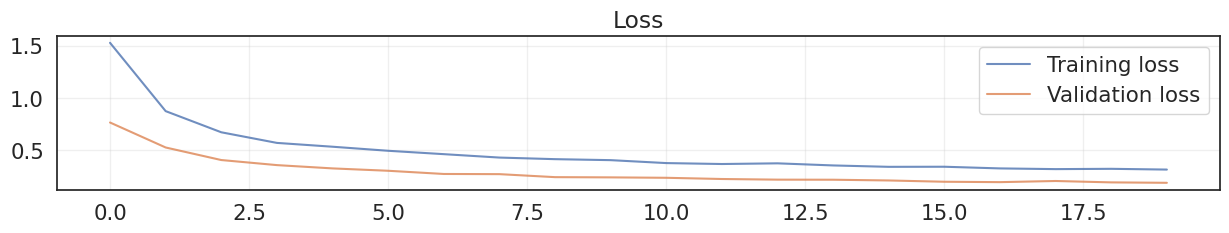

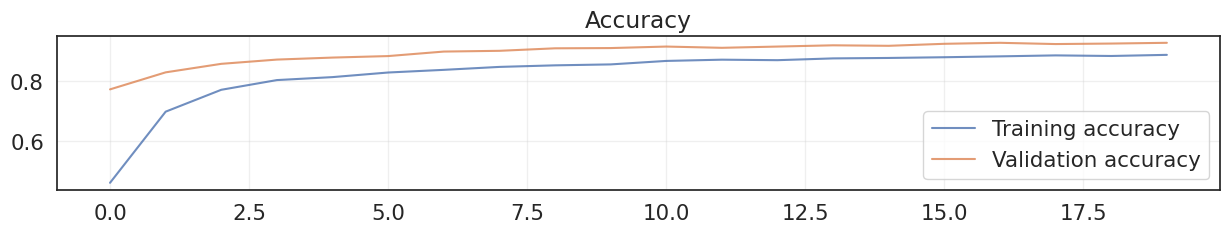

In [43]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.savefig('loss_plot.png', format='png', dpi=300)  # Save the plot as a PNG file

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.savefig('accuracy_plot.png', format='png', dpi=300)  # Save the plot as a PNG file

plt.show()  # Display the plots


## Fine-Tuning

In [44]:
! ls

CIFAR10_CNN_92.89.keras  accuracy_plot.png  model.png
CIFAR10_CNN_97.66.keras  loss_plot.png


In [45]:
# Number of training epochs
epochs = 15
batch_size = 64
learning_rate = 0.00001
patience = 10

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)
print("Early stopping with patience:", patience)

Epochs: 15
Batch Size: 64
Learning Rate: 1e-05
Early stopping with patience: 10


In [46]:
# 1. Re-load the model after transfer learning
ft_model = tfk.models.load_model('CIFAR10_CNN_92.89.keras')

In [47]:
def unfreeze_model(model):
    # We unfreeze the top 60 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-40:]:
        if not isinstance(layer, tfk.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(ft_model)

In [48]:
# 2. show the layers and their trainability
for i, layer in enumerate(ft_model.layers):
    print(i, layer.name, layer.trainable)

0 Input True
1 Resizing False
2 preprocessing True
3 conv1 False
4 conv1_bn False
5 conv1_relu False
6 conv_dw_1 False
7 conv_dw_1_bn False
8 conv_dw_1_relu False
9 conv_pw_1 False
10 conv_pw_1_bn False
11 conv_pw_1_relu False
12 conv_pad_2 False
13 conv_dw_2 False
14 conv_dw_2_bn False
15 conv_dw_2_relu False
16 conv_pw_2 False
17 conv_pw_2_bn False
18 conv_pw_2_relu False
19 conv_dw_3 False
20 conv_dw_3_bn False
21 conv_dw_3_relu False
22 conv_pw_3 False
23 conv_pw_3_bn False
24 conv_pw_3_relu False
25 conv_pad_4 False
26 conv_dw_4 False
27 conv_dw_4_bn False
28 conv_dw_4_relu False
29 conv_pw_4 False
30 conv_pw_4_bn False
31 conv_pw_4_relu False
32 conv_dw_5 False
33 conv_dw_5_bn False
34 conv_dw_5_relu False
35 conv_pw_5 False
36 conv_pw_5_bn False
37 conv_pw_5_relu False
38 conv_pad_6 False
39 conv_dw_6 False
40 conv_dw_6_bn False
41 conv_dw_6_relu False
42 conv_pw_6 False
43 conv_pw_6_bn False
44 conv_pw_6_relu False
45 conv_dw_7 False
46 conv_dw_7_bn False
47 conv_dw_7_relu Fals

In [49]:
# Train the model
history = ft_model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history


# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'CIFAR10_CNN_'+str(final_val_accuracy)+'.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy: 0.8781 - loss: 0.3355 - val_accuracy: 0.9323 - val_loss: 0.1775
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.8944 - loss: 0.2932 - val_accuracy: 0.9373 - val_loss: 0.1566
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9069 - loss: 0.2666 - val_accuracy: 0.9440 - val_loss: 0.1494
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.9114 - loss: 0.2499 - val_accuracy: 0.9448 - val_loss: 0.1390
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9147 - loss: 0.2370 - val_accuracy: 0.9498 - val_loss: 0.1277
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9085 - loss: 0.2520 - val_accuracy: 0.9615 - val_loss: 0.1200
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9236 - loss: 0.2266 - val_accuracy: 0.9666 - val_loss: 0.1025
Epoch 8/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9277 - loss: 0

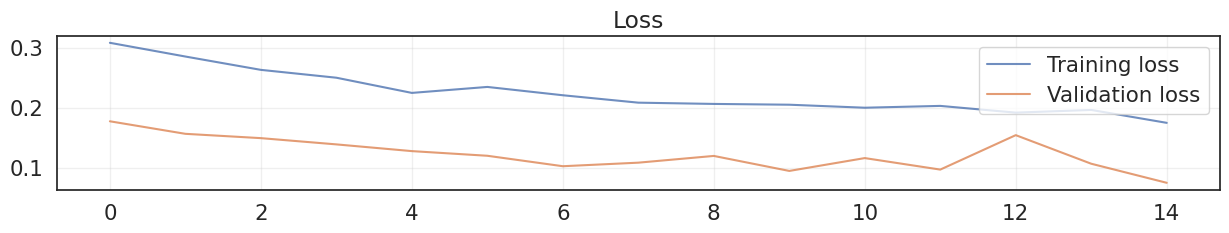

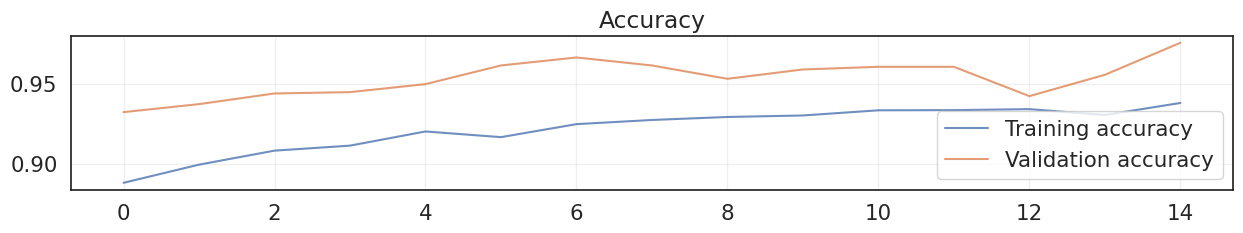

In [50]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.savefig('loss_plot.png', format='png', dpi=300)  # Save the plot as a PNG file

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.savefig('accuracy_plot.png', format='png', dpi=300)  # Save the plot as a PNG file

plt.show()  # Display the plots


In [51]:
! ls

CIFAR10_CNN_92.89.keras  CIFAR10_CNN_97.66.keras  loss_plot.png
CIFAR10_CNN_97.58.keras  accuracy_plot.png	  model.png


In [52]:
# Load the saved model
model = tfk.models.load_model('CIFAR10_CNN_97.58.keras')

In [53]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (1196, 8)


Accuracy score over the test set: 0.9758
Precision score over the test set: 0.9759
Recall score over the test set: 0.9758
F1 score over the test set: 0.9757


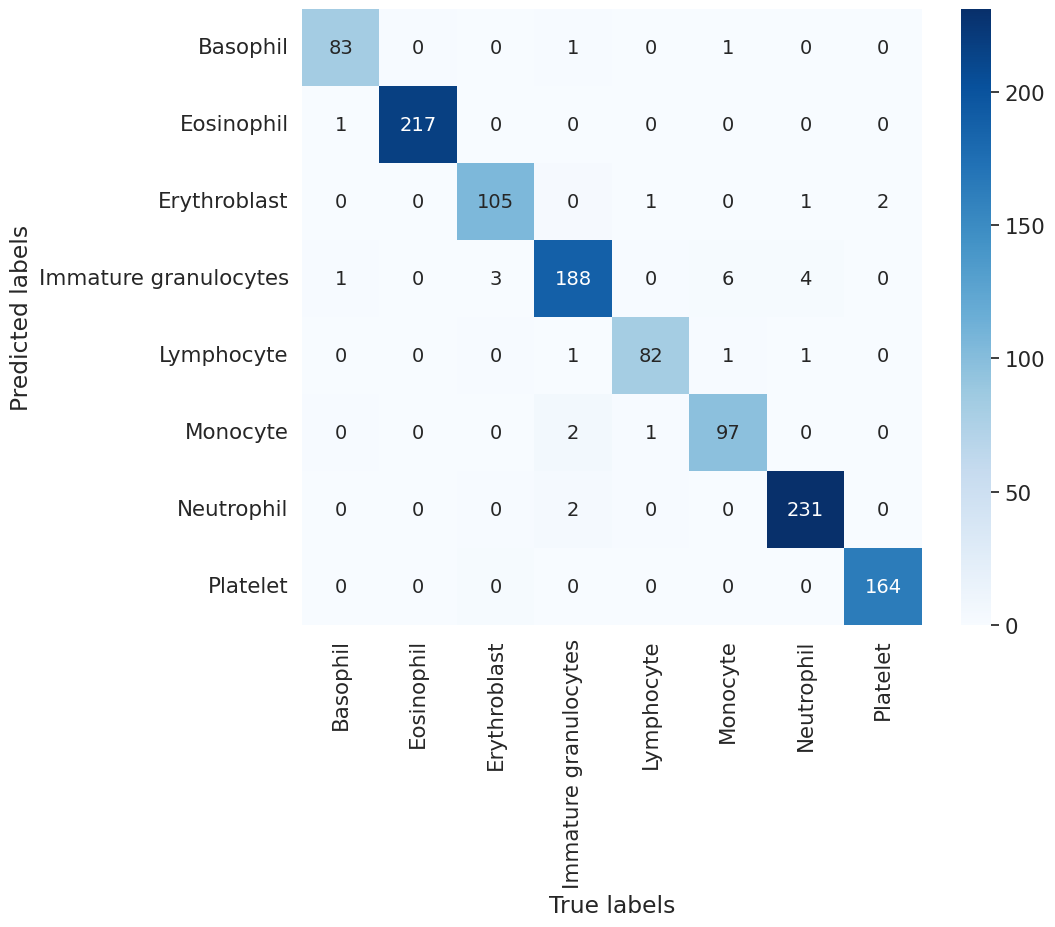

In [54]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(label_list.values()), yticklabels=list(label_list.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [55]:
# model = ...  # Add your implementation here

model.save('weights.keras')
del model

In [56]:
%%writefile model.py

import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.
        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')


    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X_resized = (X / 255.0).astype('float32')
        preds = self.neural_network.predict(X_resized)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [57]:
from datetime import datetime

# Generate a timestamped filename
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Create a zip file with the specified files
!zip -r /kaggle/working/{filename} model.py weights.keras

  adding: model.py (deflated 55%)
  adding: weights.keras (deflated 7%)
